In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv("Documents/ml-32m/ratings.csv")
movies_df = pd.read_csv('Documents/ml-32m/movies.csv')

print(df.head())
print(movies_df.head())

   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [3]:
# Merge on the 'movieId' column
merged_df = pd.merge(df, movies_df[['movieId', 'title']], on='movieId', how='left')

# Verify the merge
print(merged_df.head())


   userId  movieId  rating  timestamp  \
0       1       17     4.0  944249077   
1       1       25     1.0  944250228   
2       1       29     2.0  943230976   
3       1       30     5.0  944249077   
4       1       32     5.0  943228858   

                                               title  
0                       Sense and Sensibility (1995)  
1                           Leaving Las Vegas (1995)  
2  City of Lost Children, The (Cité des enfants p...  
3  Shanghai Triad (Yao a yao yao dao waipo qiao) ...  
4          Twelve Monkeys (a.k.a. 12 Monkeys) (1995)  


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000204 entries, 0 to 32000203
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
 4   title      object 
dtypes: float64(1), int64(3), object(1)
memory usage: 1.2+ GB


In [24]:
print(df['userId'].nunique()) #Number of unique users
print(df['movieId'].nunique()) #Number of unique movies

200948
84432


In [25]:
df.isnull().sum()
df.dropna(inplace=True)
df.duplicated().sum()
df.drop_duplicates(inplace=True)

In [26]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')  # If timestamps are in Unix format
df['userId'] = df['userId'].astype(int)
df.dtypes

userId                int64
movieId               int64
rating              float64
timestamp    datetime64[ns]
title                object
dtype: object

In [27]:
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")


Rows: 32000204, Columns: 5


In [28]:
df.describe()

,userId,movieId,rating,timestamp
count,3.200020e+07,3.200020e+07,3.200020e+07,32000204
mean,1.002785e+05,2.931861e+04,3.540396e+00,2010-05-30 17:39:59.573265152
min,1.000000e+00,1.000000e+00,5.000000e-01,1995-01-09 11:46:44
25%,5.005300e+04,1.233000e+03,3.000000e+00,2003-04-22 11:53:50
50%,1.002970e+05,3.452000e+03,3.500000e+00,2010-04-30 10:03:32.500000
75%,1.504510e+05,4.419900e+04,4.000000e+00,2017-08-19 15:59:05.249999872
max,2.009480e+05,2.927570e+05,5.000000e+00,2023-10-13 02:29:07
std,5.794905e+04,5.095816e+04,1.058986e+00,NaN


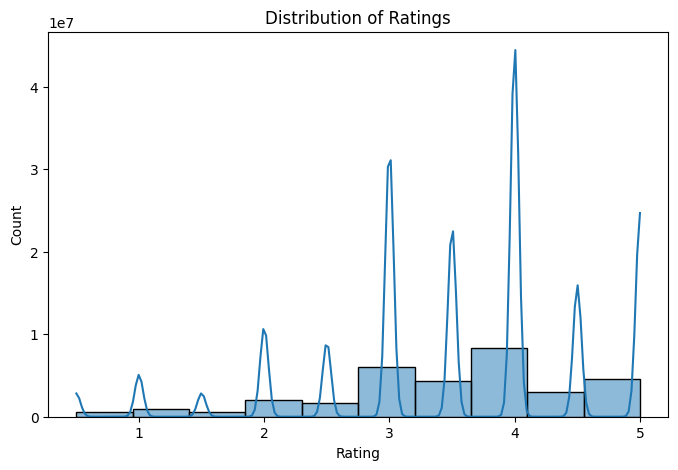

In [29]:
#  rating distribution patterns
plt.figure(figsize=(8,5))
sns.histplot(df['rating'], bins=10, kde=True)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()

In [30]:
top_items = df.groupby('movieId')['rating'].count().sort_values(ascending=False).head(10) #top rated/most reviewed movies
print(top_items)

movieId
318     102929
356     100296
296      98409
2571     93808
593      90330
260      85010
2959     77332
480      75233
527      73849
4993     73122
Name: rating, dtype: int64


In [11]:
top_avg_ratings = data.groupby('movieId')['rating'].mean().sort_values(ascending=False).head(10) #highest rated movies on average 
print(top_avg_ratings)


movieId
199103    5.0
268476    5.0
171849    5.0
268054    5.0
268090    5.0
268114    5.0
122649    5.0
225251    5.0
147402    5.0
268438    5.0
Name: rating, dtype: float64


In [12]:
popular_movies = df.groupby('movieId').filter(lambda x: x['rating'].count() > 10)
top_avg_ratings = popular_movies.groupby('movieId')['rating'].mean().sort_values(ascending=False).head(10)
print(top_avg_ratings)


movieId
102672    4.500000
171011    4.446830
159817    4.444369
223011    4.441176
170705    4.426539
318       4.404614
203847    4.400000
171331    4.395833
240686    4.363636
171495    4.330081
Name: rating, dtype: float64


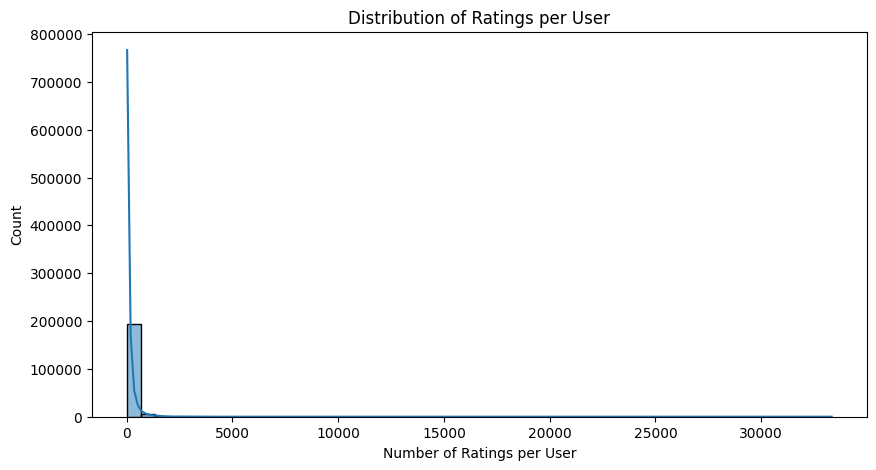

In [13]:
# "who rates the most"
user_rating_counts = df.groupby('userId')['rating'].count()
plt.figure(figsize=(10, 5))
sns.histplot(user_rating_counts, bins=50, kde=True)
plt.xlabel("Number of Ratings per User")
plt.ylabel("Count")
plt.title("Distribution of Ratings per User")
plt.show()

Recommendation System

In [14]:
top_movies = df.groupby('movieId')['rating'].count().sort_values(ascending=False).head(10)
print(top_movies)

movieId
318     102929
356     100296
296      98409
2571     93808
593      90330
260      85010
2959     77332
480      75233
527      73849
4993     73122
Name: rating, dtype: int64


In [15]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

# Filter down the dfset
df_sample = df.sample(frac=0.1, random_state=42)  # Keep only 10% of the df

# Create user and item mappings
user_ids = df_sample['userId'].astype('category').cat.codes
movie_ids = df_sample['movieId'].astype('category').cat.codes

# Create a sparse matrix
ratings_sparse = csr_matrix((df_sample['rating'], (user_ids, movie_ids)))

In [16]:
from sklearn.neighbors import NearestNeighbors

# Initialize the model with sparse matrix support
model = NearestNeighbors(metric='cosine', algorithm='brute')

# Fit on the sparse matrix (faster than computing full similarity)
model.fit(ratings_sparse)


NearestNeighbors(algorithm='brute', metric='cosine')

In [17]:
# Find the 5 most similar users to user index 10
distances, indices = model.kneighbors(ratings_sparse[10], n_neighbors=5)

print("Most similar users:", indices.flatten())
print("Similarity scores:", distances.flatten())

Most similar users: [    10 112561 147052  49153  34819]
Similarity scores: [0.         0.2116175  0.33103527 0.33103527 0.33103527]


Generate movie recommendations based on similar users' preferences

Step 1: Get a User’s Ratings
Pick a user and find the movies they have already rated.

In [18]:
user_idx = 10  # or any other users

# Get the movies this user has rated
user_ratings = ratings_sparse[user_idx].toarray().flatten()

# Get movie indices that the user has already rated
rated_movies = np.where(user_ratings > 0)[0]

print(f"User {user_idx} has rated {len(rated_movies)} movies.")


User 10 has rated 3 movies.


Step 2: Get the Most Similar Users

Retrieve the 5 most similar users using the NearestNeighbors model.

In [19]:
# Find similar users
distances, similar_users = model.kneighbors(ratings_sparse[user_idx], n_neighbors=6)

# Exclude the first user (it’s the target user themselves)
similar_users = similar_users.flatten()[1:]

print(f"Most similar users to {user_idx}: {similar_users}")


Most similar users to 10: [112561 147052  49153  34819  87628]


Step 3: Aggregate Ratings from Similar Users

What these similar users have rated highly and recommend movies that the target user hasn’t watched yet.

In [20]:
# Aggregate ratings from similar users
similar_users_ratings = ratings_sparse[similar_users].toarray().mean(axis=0)

# Exclude movies the user has already rated
similar_users_ratings[rated_movies] = 0  

# Get the top 5 recommended movie indices
recommended_movie_indices = similar_users_ratings.argsort()[::-1][:5]  

print(f"Recommended movies for user {user_idx}: {recommended_movie_indices}")

Recommended movies for user 10: [42808 14275 14273 14272 14271]


Step 4: Convert Movie Indices to Movie Titles

Since the dfset uses numeric movie IDs, we need to map them back to actual movie titles using the original dfset (df).

# Map movie indices back to movie IDs
movie_id_mapping = dict(enumerate(df_sample['movieId'].astype('category').cat.categories))
recommended_movie_ids = [movie_id_mapping[idx] for idx in recommended_movie_indices]

# Get movie titles from the dfset
recommended_movies = df[df['movieId'].isin(recommended_movie_ids)]['title'].unique()

print("Top 5 Movie Recommendations:", recommended_movies)

In [21]:
# Map movie indices back to movie IDs
movie_id_mapping = dict(enumerate(df_sample['movieId'].astype('category').cat.categories))
recommended_movie_ids = [movie_id_mapping[idx] for idx in recommended_movie_indices]

# Debugging: Print recommended movie indices
print("Recommended movie indices from sparse matrix:", recommended_movie_indices)

# Debugging: Check the mapping
print("Movie ID mapping example:", list(movie_id_mapping.items())[:10])  # Show first 10 mappings

# Convert matrix indices to actual movie IDs
recommended_movie_ids = [movie_id_mapping[idx] for idx in recommended_movie_indices if idx in movie_id_mapping]

# Debugging: Print recommended movie IDs
print("Mapped Movie IDs:", recommended_movie_ids)

Recommended movie indices from sparse matrix: [42808 14275 14273 14272 14271]
Movie ID mapping example: [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10)]
Mapped Movie IDs: [292755, 80653, 80648, 80646, 80641]


In [22]:
# Convert movieId column to the same type as recommended_movie_ids
df['movieId'] = df['movieId'].astype(int)  # Ensure movieId is integer
recommended_movies = df[df['movieId'].isin(recommended_movie_ids)]['title'].unique()

print("Top 5 Movie Recommendations:", recommended_movies)

KeyError: 'title'